# Random Forest Classifier

In this notebook, we use a random forest classifier to predict whether the prior-authorization form is approved. 

We first import all the necessary packages. 

In [1]:
## List of all packages to be imported

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("darkgrid")

## To do a train-test split and to perform cross-validation
from sklearn.model_selection import train_test_split, StratifiedKFold

## Performace metrics for classification algorithms
from sklearn.metrics import roc_auc_score,accuracy_score, recall_score

## For a random forest classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Now, let's do a train-test split. We use a random seed to be consistent with the other files. 

In [2]:
## Import cleaned CSV (no date information)
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)

## Separate the features from the output
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()

## Train-test split
X_train,X_test,y_train,y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

## k-fold cross validation to tune the hyperparameters
kfold = StratifiedKFold(5, shuffle=True, random_state=10475)

We would like to tune the following hyperparameters for the random forest:
* max_depth - The depth of each of the trees in the forest
* n_estimators - The number of estimators in the forest
* max_features - The maximum number of features for each tree (?)

## Tuning max_depth

In [3]:
## We set n_estimators = 100 for tuning
n_estimators = 100;

## We train a forest with max_depth atmost max_test_depth
max_test_depth = 10;
depths = range(1,max_test_depth+1)

## To store the cross-validation accuracy and roc-auc scores of the classifiers for each depth
forest_cv_accs = np.zeros((5,len(depths)))
forest_cv_aucs = np.zeros((5,len(depths)))
forest_cv_recall = np.zeros((5,len(depths)))

## Training the models on each of the cross-validation sets
i = 0 #To keep track of the cross-validation set while writing to forest_cv_a*cs
for train_index, test_index in kfold.split(X_train,y_train):
    X_train_train = X_train.iloc[train_index];
    X_holdout = X_train.iloc[test_index,:];
    y_train_train = y_train.iloc[train_index];
    y_holdout = y_train.iloc[test_index];
    
    j = 0 #To keep track of the depth while writing to forest_cv_a*cs 
    for depth in depths:
        forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth,random_state=10475);
        forest.fit(X_train_train,y_train_train);
        forest_cv_accs[i,j] = accuracy_score(y_holdout,forest.predict(X_holdout))
        forest_cv_aucs[i,j] = roc_auc_score(y_holdout,forest.predict_proba(X_holdout)[:,1])
        forest_cv_recall[i,j] = recall_score(y_holdout,forest.predict(X_holdout))
        j += 1;
    i += 1;

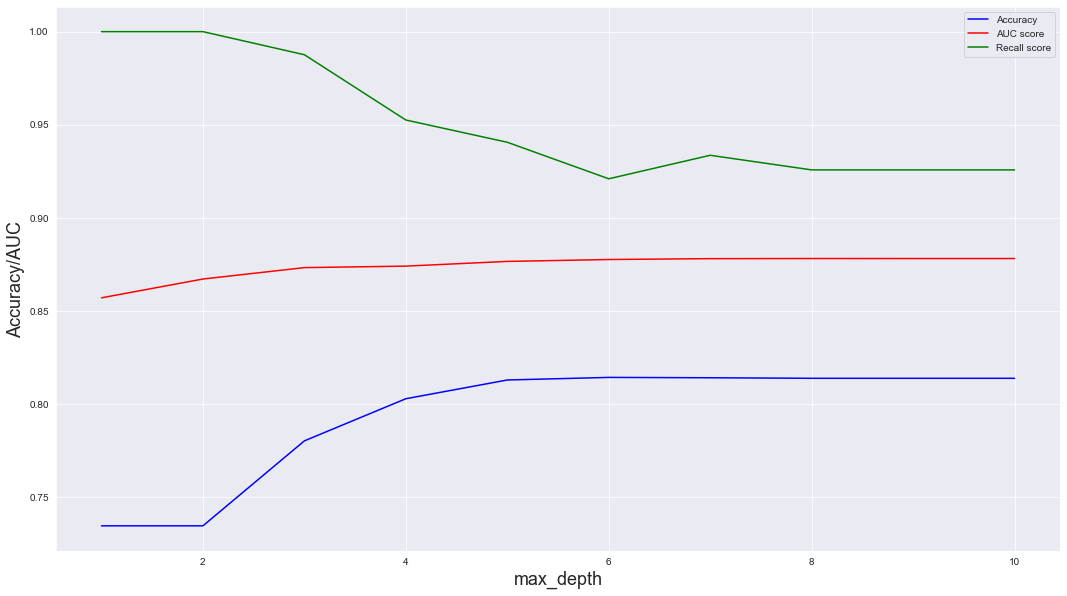

In [4]:
## Average Accuracy and AUC score
forest_acc_mean = forest_cv_accs.mean(0)
forest_auc_mean = forest_cv_aucs.mean(0)
forest_recall_mean = forest_cv_recall.mean(0)

#Plot the Accuracy/AUC vs depth
plt.figure(figsize=(18,10));
plt.plot(depths,forest_acc_mean,'b')
plt.plot(depths,forest_auc_mean,'r')
plt.plot(depths,forest_recall_mean,'g')
plt.legend(["Accuracy","AUC score","Recall score"])
plt.xlabel("max_depth",fontsize=18)
plt.ylabel("Accuracy/AUC",fontsize=18)
plt.show()

We see that the accuracy is maximized when max_depth=6 and the AUC score is maximized when max_depth = 8, (after which it remains the same). 

In [5]:
print(forest_acc_mean)
print(forest_auc_mean)

[0.73445229 0.73445229 0.78011512 0.8027498  0.81281815 0.81420766
 0.8140188  0.81372426 0.81372426 0.81372426]
[0.85697288 0.86707227 0.87319648 0.87400514 0.87653355 0.87755284
 0.87801799 0.87809467 0.87808299 0.87808309]


## Tuning n_estimators

In [6]:
## We set max_depth = 2 to tune the hyperparameter n_estimators 
max_depth = 2;

## We train a forest with n_estimator atmost max_test_depth
max_n_estimators = 100;
n_estimators_list = range(1,max_n_estimators);

## To store the cross-validation accuracy and roc-auc scores of the classifiers for each depth
forest_cv_accs = np.zeros((5,len(n_estimators_list)))
forest_cv_aucs = np.zeros((5,len(n_estimators_list)))

## Training the models on each of the cross-validation sets
i = 0 #To keep track of the cross-validation set
for train_index, test_index in kfold.split(X_train,y_train):
    X_train_train = X_train.iloc[train_index];
    X_holdout = X_train.iloc[test_index,:];
    y_train_train = y_train.iloc[train_index];
    y_holdout = y_train.iloc[test_index];
    
    j = 0 #To keep track of the n_estimators 
    for n_estimators in n_estimators_list:
        forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,random_state=10475);
        forest.fit(X_train_train,y_train_train);
        forest_cv_accs[i,j] = accuracy_score(y_holdout,forest.predict(X_holdout))
        forest_cv_aucs[i,j] = roc_auc_score(y_holdout,forest.predict_proba(X_holdout)[:,1])
        j += 1;
    i += 1;

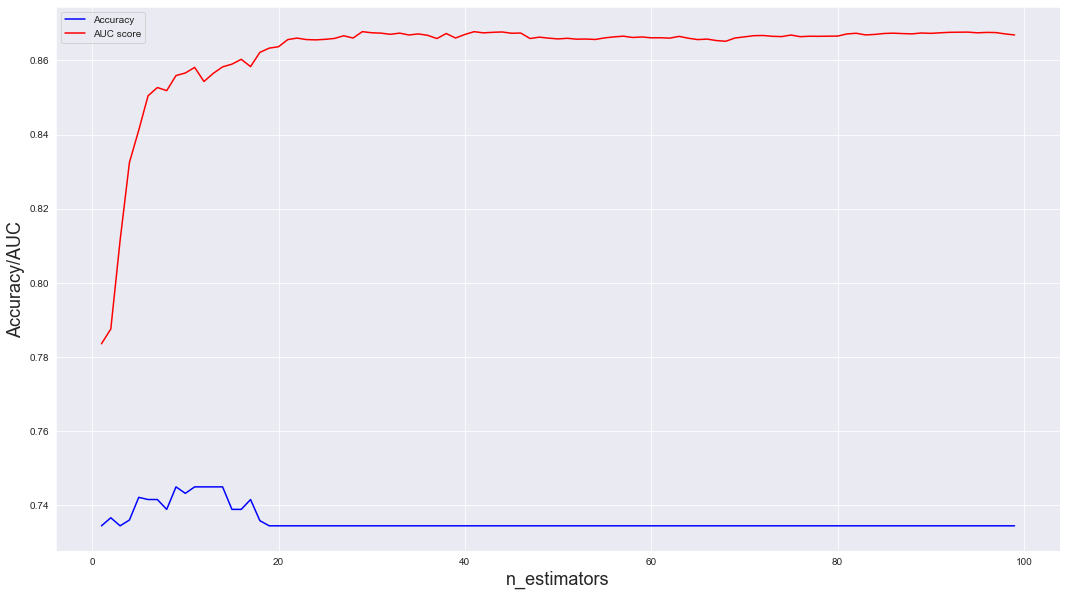

In [7]:
## Average Accuracy and AUC score
forest_acc_mean = forest_cv_accs.mean(0)
forest_auc_mean = forest_cv_aucs.mean(0)

#Plot the Accuracy/AUC vs depth
plt.figure(figsize=(18,10));
plt.plot(n_estimators_list,forest_acc_mean,'b')
plt.plot(n_estimators_list,forest_auc_mean,'r')
plt.legend(["Accuracy","AUC score"])
plt.xlabel("n_estimators",fontsize=18)
plt.ylabel("Accuracy/AUC",fontsize=18)
plt.show()

We see that the accuracy is maximized when max_depth=6 and the AUC score is maximized when max_depth = 8, (after which it remains the same). 

In [8]:
print(forest_acc_mean.argmax())
print(forest_auc_mean.argmax())

8
28


### Tuning n_estimators with a different max_depth. 

In [9]:
## We set max_depth = 3 to tune the hyperparameter n_estimators 
max_depth = 3;

## We train a forest with n_estimator atmost max_test_depth
max_n_estimators = 100;
n_estimators_list = range(1,max_n_estimators);

## To store the cross-validation accuracy and roc-auc scores of the classifiers for each depth
forest_cv_accs = np.zeros((5,len(n_estimators_list)))
forest_cv_aucs = np.zeros((5,len(n_estimators_list)))

## Training the models on each of the cross-validation sets
i = 0 #To keep track of the cross-validation set
for train_index, test_index in kfold.split(X_train,y_train):
    X_train_train = X_train.iloc[train_index];
    X_holdout = X_train.iloc[test_index,:];
    y_train_train = y_train.iloc[train_index];
    y_holdout = y_train.iloc[test_index];
    
    j = 0 #To keep track of the n_estimators 
    for n_estimators in n_estimators_list:
        forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,random_state=10475);
        forest.fit(X_train_train,y_train_train);
        forest_cv_accs[i,j] = accuracy_score(y_holdout,forest.predict(X_holdout))
        forest_cv_aucs[i,j] = roc_auc_score(y_holdout,forest.predict_proba(X_holdout)[:,1])
        j += 1;
    i += 1;

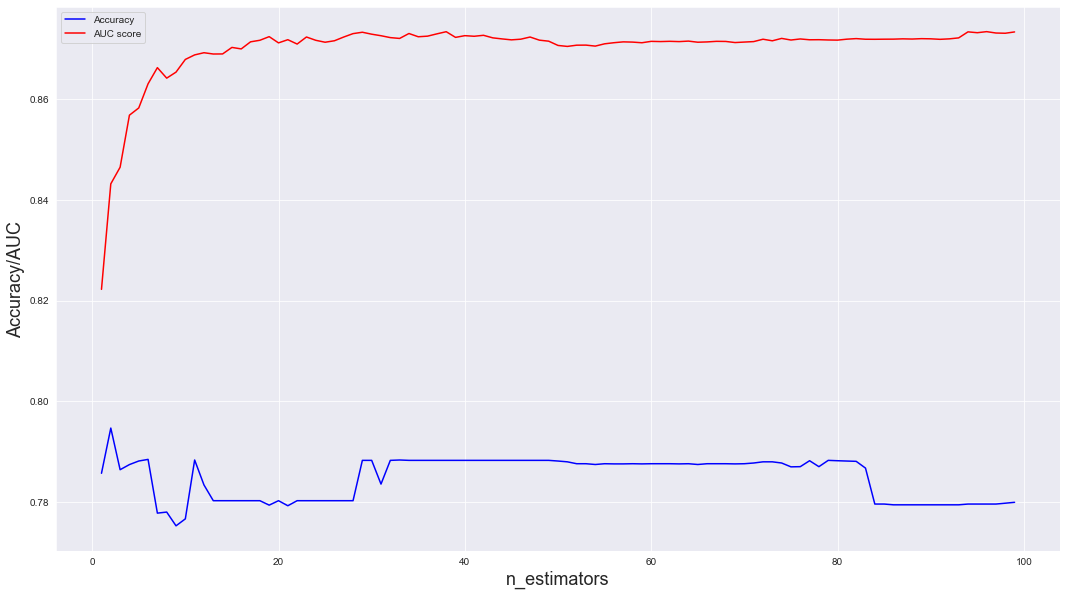

In [10]:
## Average Accuracy and AUC score
forest_acc_mean = forest_cv_accs.mean(0)
forest_auc_mean = forest_cv_aucs.mean(0)

#Plot the Accuracy/AUC vs depth
plt.figure(figsize=(18,10));
plt.plot(n_estimators_list,forest_acc_mean,'b')
plt.plot(n_estimators_list,forest_auc_mean,'r')
plt.legend(["Accuracy","AUC score"])
plt.xlabel("n_estimators",fontsize=18)
plt.ylabel("Accuracy/AUC",fontsize=18)
plt.show()

### Final Model and Performance on Training set

From the above graphs, we decide to go with the Random Forest Classifier with max_depth = 6 and n_estimators = 25. 

In [11]:
forest = RandomForestClassifier(n_estimators=25,max_depth=6)
forest.fit(X_train,y_train);
print("Accuracy on training set: ",accuracy_score(y_train,forest.predict(X_train)))
print("AUC score on training set: " ,roc_auc_score(y_train,forest.predict_proba(X_train)[:,1]))

Accuracy on training set:  0.8141739365050814
AUC score on training set:  0.876550789051276
